# Applying Neutrophil and Monocyte Signatures using Top Features

**Gregory Way, 2018**

Instead of focusing only on two compressed gene set features, like we did in [notebook 3](https://github.com/greenelab/BioBombe/blob/master/8.gtex-interpret/3.apply-signatures.ipynb), we apply all of the signatures in the following plots to their external validation data.


## Part 1:

### Enrichment of Neutrophil Signatures

Publicly available dataset capturing neutrophil differentiation in two leukemia cell lines.

![cell_type_Neutrophils_HPCA_2.png](https://github.com/greenelab/BioBombe/raw/master/6.biobombe-projection/figures/GTEX/signal/GpXCELL/gene_set_Neutrophils_HPCA_2.png)

## Part 2:

### Enrichment of Monocyte Signatures

Publicly available dataset that captures various cell-types undergoing hematopoiesis.

![cell_type_Monocytes_FANTOM_2.png](https://github.com/greenelab/BioBombe/raw/master/6.biobombe-projection/figures/GTEX/signal/GpXCELL/gene_set_Monocytes_FANTOM_2.png)

## Output

We output scores for all compression feature scores for both validation data sets.
There are a total of 5 * 28 = 140 scores per dataset

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.utils import (
    load_weight_matrix,
    apply_signature,
    load_enrichment_results,
    extract_feature,
)

sys.path.append('../scripts')
from latent import parse_gmt

In [2]:
genesets = ['Neutrophils_HPCA_2', 'Monocytes_FANTOM_2']

In [3]:
# Get top scores across algorithms and z dimensions
score_dir = os.path.join("..", "6.biobombe-projection", "results", "gtex",
                         "gpxcell", "signal")

full_list = []
for score_file in os.listdir(score_dir):
    score_file = os.path.join(score_dir, score_file)
    
    top_df = pd.read_table(score_file)
    top_df = (
        top_df
        .query("variable in @genesets")
        .assign(abs_z_score=top_df.z_score.abs())
        .sort_values(by='abs_z_score', ascending=False)
        .groupby(['z', 'algorithm', 'variable'])
        .first()
        .reset_index()
    )
    
    full_list.append(top_df)

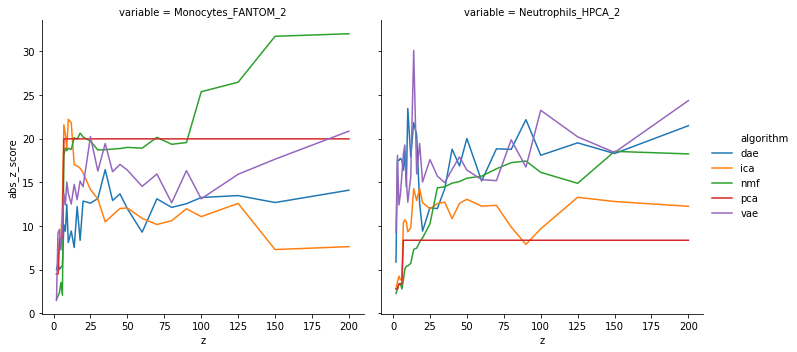

In [4]:
# Confirm extraction worked (note different colors)
full_top_df = pd.concat(full_list)

sns.relplot(x="z", y="abs_z_score", hue="algorithm", data=full_top_df,
            col='variable', kind='line')

In [5]:
# Compile feature matrix for each geneset
neutrophil_list = []
monocyte_list = []
for idx, feature in full_top_df.iterrows():
    z_dim = feature.z
    seed = feature.seed
    algorithm = feature.algorithm
    feature_num = feature.feature
    geneset = feature.variable
    weight_df = load_weight_matrix(dataset='GTEX',
                                   z_dim=z_dim,
                                   seed=seed)
    feature_df = extract_feature(weight_df=weight_df,
                                 algorithm=algorithm,
                                 feature=feature_num)

    rename_feature = '{}_zdim_{}_seed_{}'.format(feature_df.name, z_dim, seed)
    feature_df = feature_df.rename(rename_feature)
    
    if geneset == "Neutrophils_HPCA_2":
        neutrophil_list.append(feature_df)
    else:
        monocyte_list.append(feature_df)

In [6]:
neutrophil_df = pd.concat(neutrophil_list, axis='columns')
monocyte_df = pd.concat(monocyte_list, axis='columns')

## 1.0. Load External Neutrophil Dataset

In [7]:
file = os.path.join('data', 'GSE103706_processed_matrix.tsv.gz')
geo_scaled_zeroone_df = pd.read_table(file, index_col=0)

print(geo_scaled_zeroone_df.shape)
geo_scaled_zeroone_df.head(2)

(14, 18606)


,1,2,9,12,13,14,15,16,18,19,...,105371242,105373377,105375205,105377595,105379554,106821730,107282092,107984155,107984923,107987479
"HL-60, DMSO+Nutridoma, day 6, replicate 1",0.928066,1.000000,0.131285,0.0,0.0,0.258895,0.0,0.097450,0.899518,1.000000,...,0.0,0.0,0.456063,0.0,0.230915,0.000000e+00,0.161967,0.0,0.233555,0.280561
"HL-60, DMSO+Nutridoma, day 6, replicate 2",0.520178,0.782566,0.217753,0.0,0.0,0.000000,1.0,0.016712,0.321479,0.622087,...,0.0,0.0,0.263193,0.0,0.000015,5.445048e-210,0.231850,0.0,0.266596,0.163936


## 1.1. Apply Signature from All Top Features

In [8]:
neutrophil_result_df, missing_genes = (
    apply_signature(weight_df=neutrophil_df,
                    other_df=geo_scaled_zeroone_df,
                    align=True)
)

top_compressed_features = neutrophil_result_df.columns.tolist()
len(missing_genes)

336

## 1.2. Combine Data and Add Phenotype Information

In [9]:
# Process phenotype data
cell_line = [x[0] for x in neutrophil_result_df.index.str.split(',')]
treatment = [x[1] for x in neutrophil_result_df.index.str.split(',')]
day = [x[2].strip(' ') if 'replicate' not in x[2] else 'day 0'
       for x in neutrophil_result_df.index.str.split(',')]

In [10]:
neutrophil_result_df = (
    neutrophil_result_df
    .assign(cell_line=cell_line,
            treatment=treatment,
            day=day)
    .reset_index()
    .rename(columns={'index': 'full_id'})
)

recode_labels = {' not differentiated': 'control',
                 ' DMSO': 'treated',
                 ' DMSO+Nutridoma': 'treated'}

neutrophil_result_df.treatment = neutrophil_result_df.treatment.replace(recode_labels)

neutrophil_result_df.head(2)

,full_id,dae_2_zdim_16_seed_486191,ica_11_zdim_16_seed_486191,nmf_6_zdim_16_seed_451283,pca_6_zdim_16_seed_451283,vae_3_zdim_16_seed_486191,dae_38_zdim_90_seed_486191,ica_32_zdim_90_seed_165158,nmf_6_zdim_90_seed_165158,pca_6_zdim_90_seed_451283,...,pca_6_zdim_70_seed_908341,vae_39_zdim_70_seed_908341,dae_3_zdim_5_seed_451283,ica_3_zdim_5_seed_165158,nmf_3_zdim_5_seed_908341,pca_3_zdim_5_seed_451283,vae_4_zdim_5_seed_451283,cell_line,treatment,day
0,"HL-60, DMSO+Nutridoma, day 6, replicate 1",-39.919747,-0.071207,381.168098,7.721969,-39.466861,-44.057067,-0.074779,297.875570,7.721969,...,7.721969,-11.016774,-11.765697,-0.024717,323.658711,-3.214268,-51.044722,HL-60,treated,day 6
1,"HL-60, DMSO+Nutridoma, day 6, replicate 2",-26.300300,-0.035471,235.998125,5.442880,-26.956496,-35.153447,-0.060117,193.347433,5.442879,...,5.442879,-6.925572,-6.134681,-0.004224,212.694303,-0.801770,-43.551724,HL-60,treated,day 6


## 1.3. Perform t-test on Treatment vs. Control

In [11]:
ttest_results = []
for compressed_feature in top_compressed_features:
    signature_df = neutrophil_result_df.loc[:, [compressed_feature, 'treatment']]
    treatment_values = signature_df.query("treatment == 'treated'").iloc[:, 0].values
    control_values = signature_df.query("treatment == 'control'").iloc[:, 0].values
    
    t_stat, t_p = ttest_ind(treatment_values, control_values)
    ttest_results.append(pd.Series([compressed_feature, t_stat, t_p]))

In [12]:
t_results_df = pd.concat(ttest_results, axis='columns').transpose()
t_results_df.columns = ['feature', 't_stat', 't_p']
t_results_df = t_results_df.assign(neg_log_p = -np.log10(t_results_df.t_p.astype(np.float64)))
t_results_df.head()

,feature,t_stat,t_p,neg_log_p
0,dae_2_zdim_16_seed_486191,-4.13724,0.00137758,2.860883
1,ica_11_zdim_16_seed_486191,-9.67954,5.08603e-07,6.293621
2,nmf_6_zdim_16_seed_451283,4.27682,0.00107504,2.968574
3,pca_6_zdim_16_seed_451283,8.75567,1.47508e-06,5.831185
4,vae_3_zdim_16_seed_486191,-8.10521,3.28833e-06,5.483025


In [13]:
neutrophils_top_df = full_top_df.query("variable == 'Neutrophils_HPCA_2'")
neutrophils_top_df.head(2)

,z,algorithm,variable,model_type,value,z_score,feature,seed,abs_z_score
1,16,dae,Neutrophils_HPCA_2,real,-1.979560,-20.4156,2,486191,20.4156
3,16,ica,Neutrophils_HPCA_2,real,-0.001267,-12.9017,11,486191,12.9017


## 1.4. Compile and Output Plotting Data

In [14]:
final_neutrophil_results_df = (
    pd.DataFrame(t_results_df
                 .feature
                 .str
                 .split('_')
                 .values
                 .tolist(),
                 columns=['algorithm',
                          'feature_num',
                          "drop_z",
                          "z_dim",
                          "drop_seed",
                          "seed"])
    .merge(t_results_df,
           left_index=True,
           right_index=True)
    .drop(['drop_z',
           'drop_seed',
           'feature'],
          axis='columns')
)

final_neutrophil_results_df.loc[:, 'z_dim'] = final_neutrophil_results_df.z_dim.astype(np.int64)
final_neutrophil_results_df.loc[:, 'feature_num'] = final_neutrophil_results_df.feature_num.astype(np.int64)
final_neutrophil_results_df.loc[:, 'seed'] = final_neutrophil_results_df.seed.astype(np.int64)

final_neutrophil_results_df = (
    final_neutrophil_results_df
    .merge(neutrophils_top_df,
           left_on=['algorithm', 'feature_num', 'z_dim', 'seed'],
           right_on=['algorithm', 'feature', 'z', 'seed'])
)

final_neutrophil_results_df.head()

,algorithm,feature_num,z_dim,seed,t_stat,t_p,neg_log_p,z,variable,model_type,value,z_score,feature,abs_z_score
0,dae,2,16,486191,-4.13724,0.00137758,2.860883,16,Neutrophils_HPCA_2,real,-1.979560,-20.41560,2,20.41560
1,ica,11,16,486191,-9.67954,5.08603e-07,6.293621,16,Neutrophils_HPCA_2,real,-0.001267,-12.90170,11,12.90170
2,nmf,6,16,451283,4.27682,0.00107504,2.968574,16,Neutrophils_HPCA_2,real,2.057430,7.45628,6,7.45628
3,pca,6,16,451283,8.75567,1.47508e-06,5.831185,16,Neutrophils_HPCA_2,real,0.121344,8.35789,6,8.35789
4,vae,3,16,486191,-8.10521,3.28833e-06,5.483025,16,Neutrophils_HPCA_2,real,-0.925322,-15.94360,3,15.94360


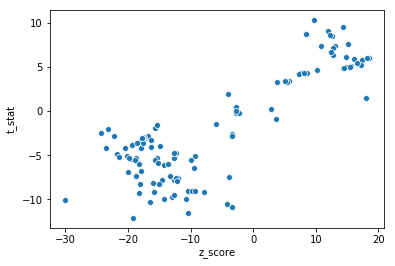

In [15]:
sns.scatterplot(x="z_score", y="t_stat", data=final_neutrophil_results_df)

In [16]:
file = os.path.join("results", "all_neutrophil_top_scores_and_separation.tsv")
final_neutrophil_results_df.to_csv(file, sep='\t', index=False)

## 2.0. Load External Monocyte Dataset

In [17]:
file = os.path.join('data', 'GSE24759_processed_matrix.tsv.gz')
heme_zeroone_df = pd.read_table(file, index_col=0)

print(heme_zeroone_df.shape)
heme_zeroone_df.head(2)

(211, 8190)


,2,9,14,16,18,19,20,22,23,25,...,100137049,100462977,100505741,100507436,100527963,100652748,102723547,105369230,107984923,107987479
BASO1_3,0.389491,0.342512,0.173372,0.196964,0.431818,0.405355,0.200679,0.580138,0.457497,0.475122,...,0.150598,0.297524,0.83302,0.410220,0.379413,0.271206,0.467457,0.842266,0.441286,0.384583
BASO1_4,0.308525,0.233696,0.281117,0.385034,0.540101,0.317294,0.262179,0.688354,0.453625,0.586759,...,0.268785,0.490944,0.77053,0.495008,0.660851,0.329928,0.365230,0.923228,0.487514,0.371348


## 2.1. Apply Signature from All Top Features and Process Data

In [18]:
result_df, missing_genes = apply_signature(weight_df=monocyte_df,
                                           other_df=heme_zeroone_df,
                                           align=True)
full_heme_result_df = result_df.reset_index().rename(columns={'index': 'cell'})

heme_cell_type_recode_df = (
    pd.DataFrame(full_heme_result_df.cell.str.split('_').values.tolist(),
                 columns = ['cell_type', 'replicate', 'additional'])
)

heme_cell_type_recode_df.loc[~heme_cell_type_recode_df.additional.isna(), 'cell_type'] = "PRE_BCELL2"

full_heme_result_df = (
    pd.concat([heme_cell_type_recode_df.drop(['additional'], axis='columns'),
               full_heme_result_df], axis='columns')
)

top_compressed_features = result_df.columns.tolist()
len(missing_genes)

3355

## 2.2. Add Phenotype Information

In [19]:
# Recode cell-type into larger classification
file = os.path.join('results', 'cell-type-classification.tsv')
cell_class_df = pd.read_table(file)

cell_updater = dict(zip(cell_class_df.label, cell_class_df.classification))
monocyte_updater = dict(zip(cell_class_df.label, cell_class_df.monocyte))

cell_class_df.head()

,label,classification,monocyte
0,HSC1,HSC,Non Monocyte
1,HSC2,HSC,Non Monocyte
2,HSC3,HSC,Non Monocyte
3,CMP,Myeloid,Non Monocyte
4,MEP,Myeloid,Non Monocyte


In [20]:
full_heme_result_df = (
    full_heme_result_df
    .assign(cell_class = full_heme_result_df.cell_type.replace(cell_updater),
            monocyte_status = full_heme_result_df.cell_type.replace(monocyte_updater))
)

full_heme_result_df.head(2)

,cell_type,replicate,cell,dae_5_zdim_16_seed_165158,ica_3_zdim_16_seed_908341,nmf_6_zdim_16_seed_908341,pca_6_zdim_16_seed_165158,vae_5_zdim_16_seed_908341,dae_59_zdim_90_seed_978124,ica_85_zdim_90_seed_486191,...,nmf_6_zdim_70_seed_451283,pca_6_zdim_70_seed_486191,vae_56_zdim_70_seed_978124,dae_4_zdim_5_seed_451283,ica_3_zdim_5_seed_165158,nmf_0_zdim_5_seed_451283,pca_3_zdim_5_seed_908341,vae_2_zdim_5_seed_908341,cell_class,monocyte_status
0,BASO1,3,BASO1_3,19.037506,-0.018817,190.557186,3.390068,-27.506036,-44.828906,0.038182,...,174.533635,3.390067,-10.164159,-1453.693733,0.001761,451.092945,2.561927,-60.916422,Basophil,Non Monocyte
1,BASO1,4,BASO1_4,20.247584,-0.022045,211.836432,3.930494,-29.972341,-48.343370,0.046172,...,195.044708,3.930494,-11.042417,-1585.421804,0.001848,496.552258,2.593208,-67.991016,Basophil,Non Monocyte


## 2.3. Perform t-test on Monocyte vs. Non-Monocyte

In [21]:
ttest_results = []
for compressed_feature in top_compressed_features:
    signature_df = full_heme_result_df.loc[:, [compressed_feature, 'monocyte_status']]
    treatment_values = signature_df.query("monocyte_status == 'Monocyte'").iloc[:, 0].values
    control_values = signature_df.query("monocyte_status == 'Non Monocyte'").iloc[:, 0].values

    t_stat, t_p = ttest_ind(treatment_values, control_values)
    ttest_results.append(pd.Series([compressed_feature, t_stat, t_p]))

In [22]:
monocyte_top_df = full_top_df.query("variable == 'Monocytes_FANTOM_2'")
monocyte_top_df.head(2)

,z,algorithm,variable,model_type,value,z_score,feature,seed,abs_z_score
0,16,dae,Monocytes_FANTOM_2,real,8.899370,12.2116,5,165158,12.2116
2,16,ica,Monocytes_FANTOM_2,real,-0.015152,-16.8709,3,908341,16.8709


In [23]:
t_results_df = pd.concat(ttest_results, axis='columns').transpose()
t_results_df.columns = ['feature', 't_stat', 't_p']
t_results_df = t_results_df.assign(neg_log_p = -np.log10(t_results_df.t_p.astype(np.float64)))
t_results_df.head()

,feature,t_stat,t_p,neg_log_p
0,dae_5_zdim_16_seed_165158,6.64893,2.52896e-10,9.597058
1,ica_3_zdim_16_seed_908341,-6.59005,3.51483e-10,9.454096
2,nmf_6_zdim_16_seed_908341,4.47722,1.24297e-05,4.905541
3,pca_6_zdim_16_seed_165158,5.45223,1.39605e-07,6.855100
4,vae_5_zdim_16_seed_908341,3.32029,0.00106107,2.974256


## 2.4. Compile and Output Plotting Data

In [24]:
full_heme_result_df = (
    pd.DataFrame(t_results_df
                 .feature
                 .str
                 .split('_')
                 .values
                 .tolist(),
                 columns=['algorithm',
                          'feature_num',
                          "drop_z",
                          "z_dim",
                          "drop_seed",
                          "seed"])
    .merge(t_results_df,
           left_index=True,
           right_index=True)
    .drop(['drop_z',
           'drop_seed',
           'feature'],
          axis='columns')
)

full_heme_result_df.loc[:, 'z_dim'] = full_heme_result_df.z_dim.astype(np.int64)
full_heme_result_df.loc[:, 'feature_num'] = full_heme_result_df.feature_num.astype(np.int64)
full_heme_result_df.loc[:, 'seed'] = full_heme_result_df.seed.astype(np.int64)

full_heme_result_df = (
    full_heme_result_df
    .merge(monocyte_top_df,
           left_on=['algorithm', 'feature_num', 'z_dim', 'seed'],
           right_on=['algorithm', 'feature', 'z', 'seed'])
)

full_heme_result_df.head()

,algorithm,feature_num,z_dim,seed,t_stat,t_p,neg_log_p,z,variable,model_type,value,z_score,feature,abs_z_score
0,dae,5,16,165158,6.64893,2.52896e-10,9.597058,16,Monocytes_FANTOM_2,real,8.899370,12.2116,5,12.2116
1,ica,3,16,908341,-6.59005,3.51483e-10,9.454096,16,Monocytes_FANTOM_2,real,-0.015152,-16.8709,3,16.8709
2,nmf,6,16,908341,4.47722,1.24297e-05,4.905541,16,Monocytes_FANTOM_2,real,34.692200,19.9185,6,19.9185
3,pca,6,16,165158,5.45223,1.39605e-07,6.855100,16,Monocytes_FANTOM_2,real,1.602070,19.9593,6,19.9593
4,vae,5,16,908341,3.32029,0.00106107,2.974256,16,Monocytes_FANTOM_2,real,3.499350,13.0083,5,13.0083


In [25]:
file = os.path.join("results", "all_monocyte_top_scores_and_separation.tsv")
full_heme_result_df.to_csv(file, sep='\t', index=False)